In [1]:
import pandas as pd
import json
import altair as alt
import matplotlib.pyplot as plt

In [2]:
movie_data = pd.read_csv('tmdb_6000_movie_dataset.csv')
movie_data.head(2)

Unnamed: 0     budget                                             genres  \
0           0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1           1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   

                                       homepage  tmdbId  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   

                                            keywords original_language  \
0  [{'id': 1463, 'name': 'culture clash'}, {'id':...                en   
1  [{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   

                                            overview  popularity  ...  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577  ...   
1  Captain Barbossa, long believed to be dead, ha...  139.082615  ...   

                                production_countries release_date     revenue  \
0  [{"iso_3166_1": "US", "name": "United States o...   2009-12-10  2787965087   
1  [{"iso_3166_1": "US", "name": "United States o...   2007-05-19   961000000   

   runtime                                   spoken_languages    status  \
0    162.0  [{"iso_639_1": "en", "name": "English"}, {"iso...  Released   
1    169.0           [{"iso_639_1": "en", "name": "English"}]  Released   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   

                                      title vote_average  vote_count  
0                                    Avatar          7.2       11800  
1  Pirates of the Caribbean: At World's End          6.9        4500  

[2 rows x 21 columns]

In [3]:
# drop columns that aren't relevant for analysis
drop_columns = ['Unnamed: 0','homepage', 'tmdbId', 'keywords','overview', 'original_language','production_companies', 'original_title', 'tagline'] 
movie_data = movie_data.drop(drop_columns, axis = 1)

In [4]:
# create new column for profit: use adjusted as that's adjusted for inflation
movie_data['profit'] = movie_data['revenue'] - movie_data['budget']

In [5]:
def standardize_quotes(row):
    '''
    some rows in the columns we're cleaning use single quotes and some use double quotes.
    this function looks at a string and converts single quotes to double quotes.
    '''
    return row.replace("'", '"')

In [6]:
# makes every row in genre column have double quotes
movie_data['genres'] = movie_data['genres'].apply(standardize_quotes)
movie_data['production_countries'] = movie_data['production_countries'].apply(standardize_quotes)
movie_data['spoken_languages'] = movie_data['spoken_languages'].apply(standardize_quotes)

In [7]:
def get_data(row, column_name):
    '''
    for a specified row of data, returns the relevant column information 
    (ie. just genres, production countries, etc.)
    '''
    # use load json to convert each row of data to a 
    # string instead of having to deal with list of dict: https://www.geeksforgeeks.org/json-load-in-python/#
    genre_list = json.loads(row[column_name])
    
    all_genres = []
    for genre in genre_list:
        all_genres.append(genre['name'])
    return all_genres

In [8]:
# args allows the function to be applied to a specific column of data
movie_data['genres'] = movie_data.apply(get_data,args=('genres',), axis=1)
movie_data['production_countries'] = movie_data.apply(get_data,args=('production_countries',), axis=1)
movie_data['spoken_languages'] = movie_data.apply(get_data,args=('spoken_languages',), axis=1)

In [9]:
def create_filter(condition, column):
    '''
    creates a filtered df which includes any row where a certain value is in a column. 
    Multiple columns have a list of values, ex. (genres, countries), 
    so this pulls a value if it appears in the row.
    '''
    filtered_rows = []
    for i in range(len(movie_data[column])):
        if condition in movie_data[column][i]:
            filtered_rows.append(movie_data.iloc[i])
    
    filtered_df = pd.DataFrame(filtered_rows)
    return filtered_df

In [10]:
# create profit ranges

bins = [-float('inf'), 0, 5000000, 10000000, 20000000, 50000000, 100000000, 200000000, 500000000, 750000000, 1000000000, float('inf')]
labels = ['Lost Money', '$0-5M', '$5-10M', '$10-20M','$20-50M','$50-100M', '$100-200M','$200-500M', '$500-750M', '$750M-1B', '$1B+']

movie_data['profit_buckets'] = pd.cut(movie_data['profit'], bins=bins, labels=labels)
movie_data.head(2)



budget                                         genres  popularity  \
0  237000000  [Action, Adventure, Fantasy, Science Fiction]  150.437577   
1  300000000                   [Adventure, Fantasy, Action]  139.082615   

                         production_countries release_date     revenue  \
0  [United States of America, United Kingdom]   2009-12-10  2787965087   
1                  [United States of America]   2007-05-19   961000000   

   runtime    spoken_languages    status  \
0    162.0  [English, Español]  Released   
1    169.0           [English]  Released   

                                      title  vote_average  vote_count  \
0                                    Avatar           7.2       11800   
1  Pirates of the Caribbean: At World's End           6.9        4500   

       profit profit_buckets  
0  2550965087           $1B+  
1   661000000      $500-750M

In [11]:
# make column of primary genre
main_genre = []
for idx, row in movie_data.iterrows():
    if len(row['genres']) >= 1:
        main_genre.append(row['genres'][0])
    else:
        main_genre.append('None')

main_genre_series = pd.Series(main_genre, name='Main Genre')

movie_data = pd.concat([movie_data, main_genre_series.to_frame()], axis=1)

In [13]:
movie_data.dropna(inplace=True)
# make column of just release year
release_yrs = []
for idx, row in movie_data.iterrows():
    release_yrs.append(int(row['release_date'][:4]))

release_yr_series = pd.Series(release_yrs, name='Release Year')

movie_data = pd.concat([movie_data, release_yr_series.to_frame()], axis=1)

In [15]:
movie_data.dropna(inplace=True)
# make column of primary production country
main_country = []
for idx, row in movie_data.iterrows():
    if len(row['production_countries']) >= 1:
        main_country.append(row['production_countries'][0])
    else:
        main_country.append('None')

main_country_series = pd.Series(main_country, name='Lead Production Country')
movie_data = pd.concat([movie_data, main_country_series.to_frame()], axis=1)

movie_data.to_csv('movie_data_master.csv', index=False)

In [16]:
# condense movie categories into fewer genres
genre_group_dict = {'Action': ['Action', 'Adventure', 'Fantasy', 'Science Fiction'],
                    'Horror': ['Horror', 'Thriller', 'Crime', 'Mystery'],
                    'Drama': ['Drama'],
                    'Comedy': ['Comedy'],
                    'Romance': ['Romance'],
                    'Family': ['Family', 'Animation'],
                    'Documentary': ['Documentary'],
                    'Other': ['War', 'Western', 'Music', 'History', 'TV Movie', 'Foreign', 'None']}

for idx, row in movie_data.iterrows():
    for genre in list(genre_group_dict.keys()):
        if row['Main Genre'] in genre_group_dict[genre]:
            movie_data.loc[idx, 'Main Genre'] = genre

In [18]:
# create df of just recent movies
recent_movies = movie_data.loc[movie_data['Release Year'] >= 2000]
recent_movies = recent_movies.loc[recent_movies['budget'] >= 100000000]
recent_movies = recent_movies.loc[recent_movies['popularity'] <= 500]

# Visualizations

In [20]:
movie_data.dropna(inplace=True)
us_movies = pd.DataFrame()
for idx, row in movie_data.iterrows():
    if 'United States of America' in row['production_countries']:
        us_movies = pd.concat([us_movies, row.to_frame().T])
us_movies.head(2)

budget                                         genres  popularity  \
0  237000000.0  [Action, Adventure, Fantasy, Science Fiction]  150.437577   
1  300000000.0                   [Adventure, Fantasy, Action]  139.082615   

                         production_countries release_date       revenue  \
0  [United States of America, United Kingdom]   2009-12-10  2787965087.0   
1                  [United States of America]   2007-05-19   961000000.0   

  runtime    spoken_languages    status  \
0   162.0  [English, Español]  Released   
1   169.0           [English]  Released   

                                      title vote_average vote_count  \
0                                    Avatar          7.2    11800.0   
1  Pirates of the Caribbean: At World's End          6.9     4500.0   

         profit profit_buckets Main Genre Release Year  \
0  2550965087.0           $1B+     Action       2009.0   
1   661000000.0      $500-750M     Action       2007.0   

    Lead Production Country  
0  United States of America  
1  United States of America

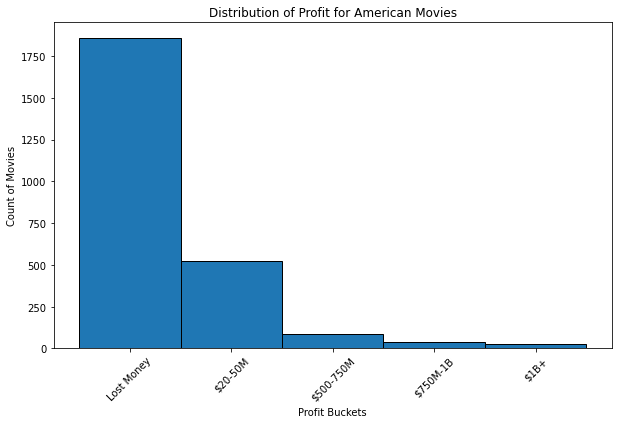

In [21]:
profit_bucket_order = ['Lost Money', '$20-50M', '$500-750M', '$750M-1B', '$1B+']

bucket_counts = us_movies['profit_buckets'].value_counts().reindex(profit_bucket_order)

plt.figure(figsize=(10, 6))
plt.bar(bucket_counts.index, bucket_counts, edgecolor='black', width = 1)

plt.title('Distribution of Profit for American Movies')
plt.xlabel('Profit Buckets')
plt.ylabel('Count of Movies')

plt.xticks(rotation=45)

plt.savefig('profit_distribution.jpeg')
plt.show()

In [22]:
# interactive 4D bubble chart
genres = list(movie_data['Main Genre'].unique())
genre_radio = alt.binding_radio(options=genres, name="Main Genre")
genre_select = alt.selection_single(fields=['Main Genre'], bind=genre_radio)

base = alt.Chart(recent_movies).mark_point(filled=True).add_selection(
    genre_select
).encode(
    alt.X('budget', axis=alt.Axis(title='Budget ($)')),
    alt.Y('popularity', axis=alt.Axis(title='Popularity')),
    opacity=alt.condition(genre_select, 'Main Genre', alt.value(0)),
    size='vote_count',
    tooltip=['title:N', 'revenue:Q']
).properties(
    width=800,
    height=300
).interactive()

genre_color_condition = alt.condition(
    genre_select,
    alt.Color('Main Genre:N'),
    alt.value('lightgray')
)

highlight_regions = base.add_selection(
    genre_select
).encode(
    color=genre_color_condition
).properties(title='Popularity vs. Budget of Movies since 2000')
highlight_regions

alt.Chart(...)

In [23]:
highlight_regions.save('bubblechart.html')

In [24]:
# stacked bar chart
recent_movies_2 = movie_data.loc[movie_data['Release Year'] >= 2000]

x_scale = list(range(2000, 2025, 1))
stacked_bar_chart = alt.Chart(recent_movies_2).mark_bar().encode(
    x=alt.X('Release Year:O', title='Release Year', scale=alt.Scale(domain=x_scale)),
    y=alt.Y('count(Main Genre)', title='Count'),
    color='Main Genre',
    size=alt.value(20)
).properties(
    width=800,
    height=400,
    title='Number of Movies Produced Each Year by Genre')

stacked_bar_chart

alt.Chart(...)

In [25]:
stacked_bar_chart.save('stacked_bar_chart.html')

In [28]:
# interactive bar chart
recent_movies_3 = movie_data[movie_data['Release Year'] >= 2000]

# dropdown selection
year_dropdown = alt.binding_select(options=sorted(recent_movies_3['Release Year'].unique()))
year_selection = alt.selection_single(fields=['Release Year'], bind=year_dropdown, name='Release Year')

average_runtime_chart = alt.Chart(recent_movies_3).transform_filter(
    year_selection
).transform_aggregate(
    average_runtime='average(runtime)',
    groupby=['Main Genre']
).mark_bar().encode(
    y=alt.Y('average_runtime:Q', title='Average Runtime (in minutes)', scale=alt.Scale(domain=[0, 160])),
    x=alt.X('Main Genre:N', title='Genre', sort='-y'),
    color=alt.Color('Main Genre:N', scale=alt.Scale(scheme='category20'))
).properties(
    title='Average Runtime by Genre for Movies in a Single Year',
    width=500
).add_selection(
    year_selection
)
average_runtime_chart

alt.Chart(...)

In [29]:
average_runtime_chart.save('average_runtime_chart.html')